In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({
    'font.size': 15,
    'font.family': 'Arial'
})
import tqdm

In [2]:
import torch
import numpy as np
import torch.distributions as dist

In [3]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 500, 10., [-5, 5])

In [4]:
X = torch.from_numpy(x_train).float()
X = torch.stack([torch.ones(len(X)), X, X**2, X**3]).T
y = torch.from_numpy(y_train).float()

In [5]:
def softplus(x):
    return torch.log(1 + torch.exp(x))


def elbo(X, y, n_sample, a0=1, b0=1, beta=0.01):
    q_alpha = dist.Gamma(softplus(a), softplus(b))
    alpha = q_alpha.rsample([n_sample])
    
    q_w = dist.MultivariateNormal(mu, covariance_matrix=softplus(scale).diag())
    w = q_w.rsample([n_sample])
    
    log_qz = q_alpha.log_prob(alpha).mean() + q_w.log_prob(w).mean()

    
    log_pxz = 0
    for i in range(n_sample):
        p_alpha = dist.Gamma(a0, b0)
        p_w = dist.MultivariateNormal(torch.zeros(4), covariance_matrix=1/alpha[i]*torch.eye(4))
        p_y = dist.Normal(0, 1/beta)
        diff = y - torch.matmul(w[i], X.T).squeeze()
        log_pxz += p_alpha.log_prob(alpha[i]) + p_w.log_prob(w).mean() + p_y.log_prob(diff).sum()
    
    log_pxz = log_pxz / n_sample
    elbo = log_pxz - log_qz
    return elbo

In [6]:
mu = torch.randn(4).requires_grad_()
scale = torch.randn(4).requires_grad_()
a = torch.ones(1).requires_grad_()
b = torch.ones(1).requires_grad_()
optimizer = torch.optim.Adam([mu, scale, a, b], lr=0.1)

In [7]:
loss_list = []
for i in tqdm.tqdm(range(2000)):
    optimizer.zero_grad()
    loss = -elbo(X, y, n_sample=10, beta=0.01)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|███████████████████████████████████████| 2000/2000 [00:23<00:00, 83.61it/s]


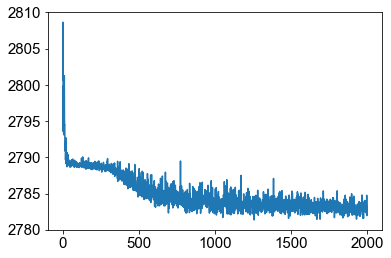

In [8]:
plt.plot(loss_list)

In [9]:
beta = 0.01
with torch.no_grad():
    S = softplus(scale).diag()
    pred = torch.matmul(X, mu)
    y_var = 1/beta + (torch.matmul(X, S) * X).sum(dim=1)
    y_std = torch.sqrt(y_var)